In [68]:
import numpy as np
from numpy.linalg import inv, multi_dot
from numpy import matmul, exp, transpose, multiply
import pandas as pd
from matplotlib import pyplot as plt
from typing import List
from scipy.optimize import minimize

In [148]:
class timeSeries():
    def __init__(self, df: pd.DataFrame, country: str, start: str, end: str):
        self.country = country
        df.loc[:,'dateRep'] = pd.to_datetime(df.dateRep, format='%d/%m/%Y')
        self.start = start
        self.end = end
        self.rawData = df
        self.allCountries = df.countriesAndTerritories.unique()
        self.processedData = self.extract_country_and_time(start, end)

    def extract_country_and_time(self, start_str: str, end_str: str) -> pd.DataFrame:
        """
        Filters the data frame by the specified time frame and countries.
        Args:
            df_path (str): default = path
            start (str): yyyy-mm-dd
            end (str): yyyy-mm-dd 
        """

        df = self.rawData.copy(deep = False)
        df = df[df.countriesAndTerritories == self.country]
        df = df[["dateRep", "day", "month", "year", "cases"]]
        df = df.sort_values(["year", "month","day"])
    
        df = df.set_index('dateRep')
        idx = pd.date_range(df.index[0], df.index[-1])
        df = df.reindex(idx, fill_value=np.nan)
        df.loc[:,"cumCases"] = df.loc[:,"cases"].interpolate(method="linear").cumsum(axis=0)

        try:
            start = pd.to_datetime(start_str)
            df = df.loc[start:]
        except:
            if (start_str != "start"):
                print("Wrong input")

        try:
            end = pd.to_datetime(end_str)
            df = df.loc[:end]
        except:
            if (end_str != "end"):
                print("Wrong input")
        
        df.loc[:,"t"] = list(range(len(df)))
                
        print(df)
        return df

    def linear_regression(self):
        """
        Returns beta of the linear regression
        and plots the prediction vs real data
        """
        df = self.processedData.copy(deep=False)
        M = len(df)
        I_0 = np.double(df.loc[df["t"] == 0, "cumCases"])
        t = np.array(df.loc[df["t"] > 0, "t"]).reshape(-1, 1)
        I = np.array(df.loc[df["t"] > 0, "cumCases"]).reshape(-1, 1)
        #! Achtung diese Zeile ist nur zum Testen
        #I = I + 20

        # Lineares Ausgleichsproblem
        X = t
        XT = t.transpose()
        y = np.log(I) - np.log(I_0)
        beta_hat = np.double(multi_dot([inv(matmul(XT, X)),XT,y])).round(4)
        prediction = I_0 * exp(beta_hat * t)
        

        fig, ax = plt.subplots(figsize = (8,5))
        ax.margins(0.05)
        country = self.country
        ax.set_title(f"{self.start} bis {self.end}, $I_0 = {int(I_0)}$", fontsize = 18)
        ax.plot(df.t[1:],prediction, label="LAP", color="red",)
        ax.plot(df.t[1:],df.cumCases[1:], label="Echte Daten", color="blue",marker=".", ls='none')
        ax.text(0.65, 0.8, f"$\hat \\beta = $ {str(beta_hat)}", transform=ax.transAxes, fontsize=18)
        plt.rc('legend',fontsize=16)

        ax.legend()
        plt.show() 
        return beta_hat
    
    def nonlinear_regression(self):
        """
        Returns the result for Newton's method
        and plots the prediction vs real data
        """
        df = self.processedData
        M = len(df)
        I_0 = np.double(df.loc[df["t"] == 0, "cumCases"])
        t = np.array(df.loc[df["t"] > 0, "t"],dtype=np.float128).reshape(-1, 1)
        I = np.array(df.loc[df["t"] > 0, "cumCases"],dtype=np.float128).reshape(-1, 1)

        # Newton's Method
        def G(x):
            return matmul(transpose(I - I_0*np.double(0.00001)*exp(x*t)), I - I_0*exp(x*t))

        print(G(0.1))

        # G'(x)
        def dGdx(x):
            return 2*I_0 * np.matmul(transpose(I_0 * exp(x*t)-I),t * exp(x * t))
            #return 2* (I_0**2) *np.sum(np.multiply(t,multiply(exp(x*t)-I/I_0,exp(x*t))))

        beta_star = np.double(minimize(G, x0=self.linear_regression(), method="Newton-CG", jac=dGdx).x).round(4)
        prediction = I_0*np.double(0.00001) * exp(beta_star * t)
        

        fig, ax = plt.subplots(figsize = (8,5))
        ax.margins(0.05)

        ax.set_title(f"{self.start} bis {self.end}, $I_0 = {int(I_0)}$", fontsize = 18)
        ax.plot(df.t[1:],prediction, label="Newton-Methode", color="red",)
        ax.plot(df.t[1:],df.cumCases[1:], label="Echte Daten", color="blue",marker=".",ls='none')
        ax.text(0.65, 0.8, f"$ \\beta^* = $ {str(beta_star)}", transform=ax.transAxes, fontsize=18)
        plt.rc('legend',fontsize=16)

        ax.legend()
        plt.show()
        return beta_star
        

             day  month    year   cases  cumCases   t
2020-01-31  31.0    1.0  2020.0     5.0     40.50   0
2020-02-01   1.0    2.0  2020.0     1.0     41.50   1
2020-02-02   NaN    NaN     NaN     NaN     42.50   2
2020-02-03   3.0    2.0  2020.0     1.0     43.50   3
2020-02-04   4.0    2.0  2020.0     4.0     47.50   4
2020-02-05   5.0    2.0  2020.0     2.0     49.50   5
2020-02-06   6.0    2.0  2020.0     1.0     50.50   6
2020-02-07   7.0    2.0  2020.0     1.0     51.50   7
2020-02-08   NaN    NaN     NaN     NaN     52.50   8
2020-02-09   NaN    NaN     NaN     NaN     53.50   9
2020-02-10  10.0    2.0  2020.0     1.0     54.50  10
2020-02-11  11.0    2.0  2020.0     3.0     57.50  11
2020-02-12  12.0    2.0  2020.0     1.0     58.50  12
2020-02-13   NaN    NaN     NaN     NaN     59.50  13
2020-02-14   NaN    NaN     NaN     NaN     60.50  14
2020-02-15  15.0    2.0  2020.0     1.0     61.50  15
2020-02-16   NaN    NaN     NaN     NaN     62.50  16
2020-02-17  17.0    2.0  202

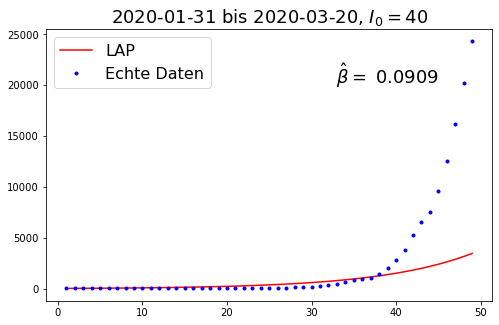

0.0909

In [149]:
df = pd.read_csv("data/europe_timeseries.csv")
ts = timeSeries(df, "Germany", "2020-01-31", "2020-03-20")
ts.linear_regression()

[[1.19748433e+09]]


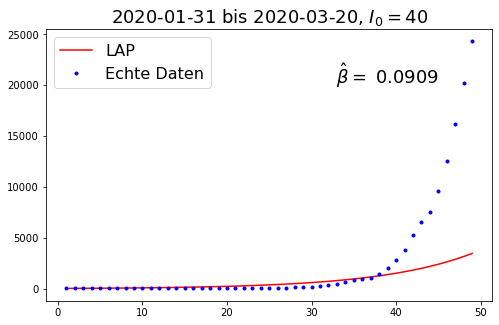

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
<ipython-input-148-7eda6b4a69aa>:102: RuntimeWarning: overflow encountered in exp
  return 2*I_0 * np.matmul(transpose(I_0 * exp(x*t)-I),t * exp(x * t))
<ipython-input-148-7eda6b4a69aa>:102: RuntimeWarning: overflow encountered in matmul
  return 2*I_0 * np.matmul(transpose(I_0 * exp(x*t)-I),t * exp(x * t))
/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:1799: RuntimeWarning: invalid value encountered in multiply
  ri = ri + alphai * Ap


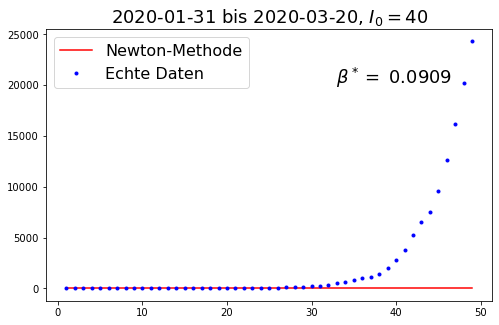

0.0909

In [151]:
ts.nonlinear_regression()

In [107]:
a =np.array([1,2,3])
a * a

array([1, 4, 9])